In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf

In [3]:
from tqdm import tqdm

In [4]:
import xarray as xr

In [5]:
from plot_config import *

In [6]:
import os
salt_path = '/sciserver/filedb12-01/ocean/wenrui_temp/centerS_normalNmean/'
salt_path = '/export/scratch/wjiang33/cooked/centerS_normalNmean/'
particle_path = '/sciserver/filedb08-01/ocean/wenrui_temp/particle_file/saltyM/table'
# os.listdir(salt_path)

In [7]:
ds = xr.open_zarr(salt_path)
tb = xr.open_zarr(particle_path)

In [8]:
just_for_time = xr.open_zarr('/sciserver/filedb12-01/ocean/wenrui_temp/advNdif_normal/')
ecco_grid = xr.open_zarr('~/ECCO_transport')
ds['time'] = just_for_time.time

In [10]:
ds['sp'] = ds['SALT'] - ds['smean']

In [11]:
itmax = salty_idate
# ds['time'][itmax]

In [12]:
izmax = 17
print(ecco_grid.Zl[izmax].values)
ds['map'] = -(ds['sp']*ecco_grid.drF)[:,:izmax].sum(dim = 'Z')/ecco_grid.Zl[izmax]

-207.16


In [13]:
ds['min'] = ds['sp'][:,:izmax].min(dim = 'Z')

In [14]:
# vmax = 0.2
# offset = 0
# plt.pcolormesh(ecco_grid.XC[2],ecco_grid.YC[2],ds['map'][itmax-offset,2],vmax = vmax, vmin = -vmax, cmap = 'bwr')
# plt.pcolormesh(ecco_grid.XC[10],ecco_grid.YC[10],ds['map'][itmax-offset,10],vmax = vmax, vmin = -vmax, cmap = 'bwr')
# plt.plot(tb.lon[offset],tb.lat[offset],'o',markersize = 0.1, color = 'gold')

In [21]:
from matplotlib.dates import date2num, num2date
from matplotlib.collections import LineCollection
from matplotlib import cm
import matplotlib.path as mpath

In [16]:
np.random.seed(111)
# andom_which = np.random.choice(where,100)
random_which = np.random.randint(0,len(tb.space),2000)

lons = np.array(tb.lon[:,random_which])
lats = np.array(tb.lat[:,random_which])

/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 31 times more chunks
  return self.array[key]


In [ ]:
def darken_color(color, factor=0.8):
    """
    Darken an RGBA color.

    Parameters:
    - color: A 4-number tuple representing an RGBA color.
    - factor: A float between 0 and 1 specifying the darkness factor.

    Returns:
    - A new 4-number tuple representing the darkened RGBA color.
    """
    r, g, b, a = color
    darkened_color = (r * factor, g * factor, b * factor, a)
    return darkened_color

In [17]:
times = np.array(ds['time'][itmax:itmax-3650:-1])

In [18]:
xrange = (-34,-10)
yrange = (47.5,65)
zrange = (-200,0)

lon_bool = np.logical_and(ds.XC[2]>xrange[0],ds.XC[2]<xrange[1])
lat_bool = np.logical_and(ds.YC[2]>yrange[0],ds.YC[2]<yrange[1])
dep_bool = np.logical_and(ds.Z>zrange[0],ds.Z<zrange[1])
pos_bool = np.logical_and(np.logical_and(lon_bool,lat_bool),dep_bool)

sp = ds['sp'][itmax]
init_bool = np.logical_and(sp[:,2]>0.1,pos_bool).sum(dim = 'Z')

In [22]:
def pretty_stream_plot(
    lats,
    lons,
    times,
    init_bool,
    projection,
    particle_bins=1,
    cmap = 'bwr',
    levels = [-0.15],
    extent = None,
    darken = 1.0,
    alpha = 1.0,
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as=False,
):
    spds = date2num(times)
    plt.figure(figsize=(16, 16))
    axs = plt.axes(projection=projection)
    # axs.set_facecolor("lightgrey")
    # axs.add_feature(cf.LAND, zorder=10, facecolor='grey')
    for i in [2,6,10]:
        plt.pcolormesh(ecco_grid.XC[i],ecco_grid.YC[i],ecco_grid.Depth[i], 
                       cmap = depth_cmap, norm = depth_norm,transform = ccrs.PlateCarree())
    axs.coastlines(color = 'w',resolution = '50m')
    if extent is not None:
        axs.set_extent(extent)
    n = 20
    aoi = mpath.Path(
        list(zip(np.linspace(extent[0],extent[1], n), np.full(n, extent[3]))) + \
        list(zip(np.full(n, extent[1]), np.linspace(extent[3], extent[2], n))) + \
        list(zip(np.linspace(extent[1], extent[0], n), np.full(n, extent[2]))) + \
        list(zip(np.full(n, extent[0]), np.linspace(extent[2], extent[3], n)))
    )
    axs.set_boundary(aoi, transform=ccrs.PlateCarree())
    plt.tight_layout()
    # To speed up the computation, we transform the
    # latlon outside the for plotting for-loop.
    xx, yy, _ = projection.transform_points(ccrs.PlateCarree(), lons, lats).T

    xx = xx.T
    yy = yy.T
    
    norm = plt.Normalize(np.min(spds), np.max(spds))
    
    # color_of_time = cmap(norm(date2num(ds['time'][itmax].values)))
    # plt.plot(tb.lon[0],tb.lat[0],'o',markersize = 0.1, color = color_of_time, alpha = 0.1,transform = ccrs.PlateCarree())

    levels = levels
    xc = np.array(ecco_grid.XC[[2,6,10]]).ravel()
    yc = np.array(ecco_grid.YC[[2,6,10]]).ravel()
    values = []
    colors = []
    for offset,color_of_time in zip([183,730],['darkorange','red']):
        time = ds['time'][itmax-offset].values
        # color_of_time = darken_color(cmap(norm(date2num(time))),darken)
        values.append(date2num(time))
        colors.append(color_of_time)
        ct = plt.tricontour(xc,yc,
                            np.array(ds['map'][itmax-offset,[2,6,10]]).ravel(),
                            levels = levels,
                            colors = [color_of_time],
                            transform = ccrs.PlateCarree(),zorder = 5)
        # plt.clabel(ct, fmt= str(time)[:7],fontsize = 8)
        # plt.plot(tb.lon[offset,random_which],tb.lat[offset,random_which],'D',markersize = 5, c = color_of_time)
    # color_of_time = darken_color(cmap(norm(date2num(ds['time'][itmax].values))),0.7)
    # pcm = plt.pcolormesh(ecco_grid.XC[2],ecco_grid.YC[2],init_bool,
    #              color = 'none',hatch = 'OO',
    #              # hatch = 'OO',colors='none',levels = [0,1],
    #                # cmap = 'Blues',vmax = 5,vmin =0,
    #                transform = ccrs.PlateCarree(),zorder = 0)
    # pcm.set_hatch(np.array(init_bool)>0)
    zm = np.ma.masked_less(init_bool, 0.3)
    plt.pcolor(ecco_grid.XC[2],ecco_grid.YC[2],zm, hatch='..', alpha=0.,transform = ccrs.PlateCarree(),zorder = 10)

    for i in tqdm(range(0, lons.shape[1], particle_bins)):
        y = yy.T[i][1:]
        x = xx.T[i][1:]
        if np.max(x) - np.min(x) > 300:
            x[x < 0] += 360
        dydx = (0.5 * (spds[:-1] + spds[1:]))[1:]  # first derivative

        # Create a set of line segments so that we can color them individually
        # This creates the points as a N x 1 x 2 array so that we can stack points
        # together easily to get the segments. The segments array for line collection
        # needs to be (numlines) x (points per line) x 2 (for x and y)
        points = np.array([x, y]).T.reshape(-1, 1, 2)

        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # Create a continuous norm to map from data points to colors
        lc = LineCollection(segments, cmap=cmap, norm=norm,lw = 0.01,alpha = alpha,zorder=1)
        # Set the values used for colormapping
        lc.set_array(dydx)
        lc.set_linewidth(0.3)
        axs.add_collection(lc)
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, location = 'bottom')
    year0 = int(np.datetime_as_string(times[-1], unit='Y'))
    year1 = int(np.datetime_as_string(times[0], unit='Y'))
    labels = np.arange(year0+1, year1+1)
    date_ticks = [date2num(np.datetime64(str(label))) for label in labels]
    cbar.set_ticks(date_ticks)
    cbar.set_ticklabels(labels)

    # Add a notch at a specific value with a given color
    for i,value in enumerate(values):
        cbar.ax.axvline(value, color=colors[i], linewidth=2, linestyle='--')
    if save_as:
        plt.savefig(save_as+'.png', dpi = dpi)

/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/wjiang33/miniconda3/envs/jit/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decre

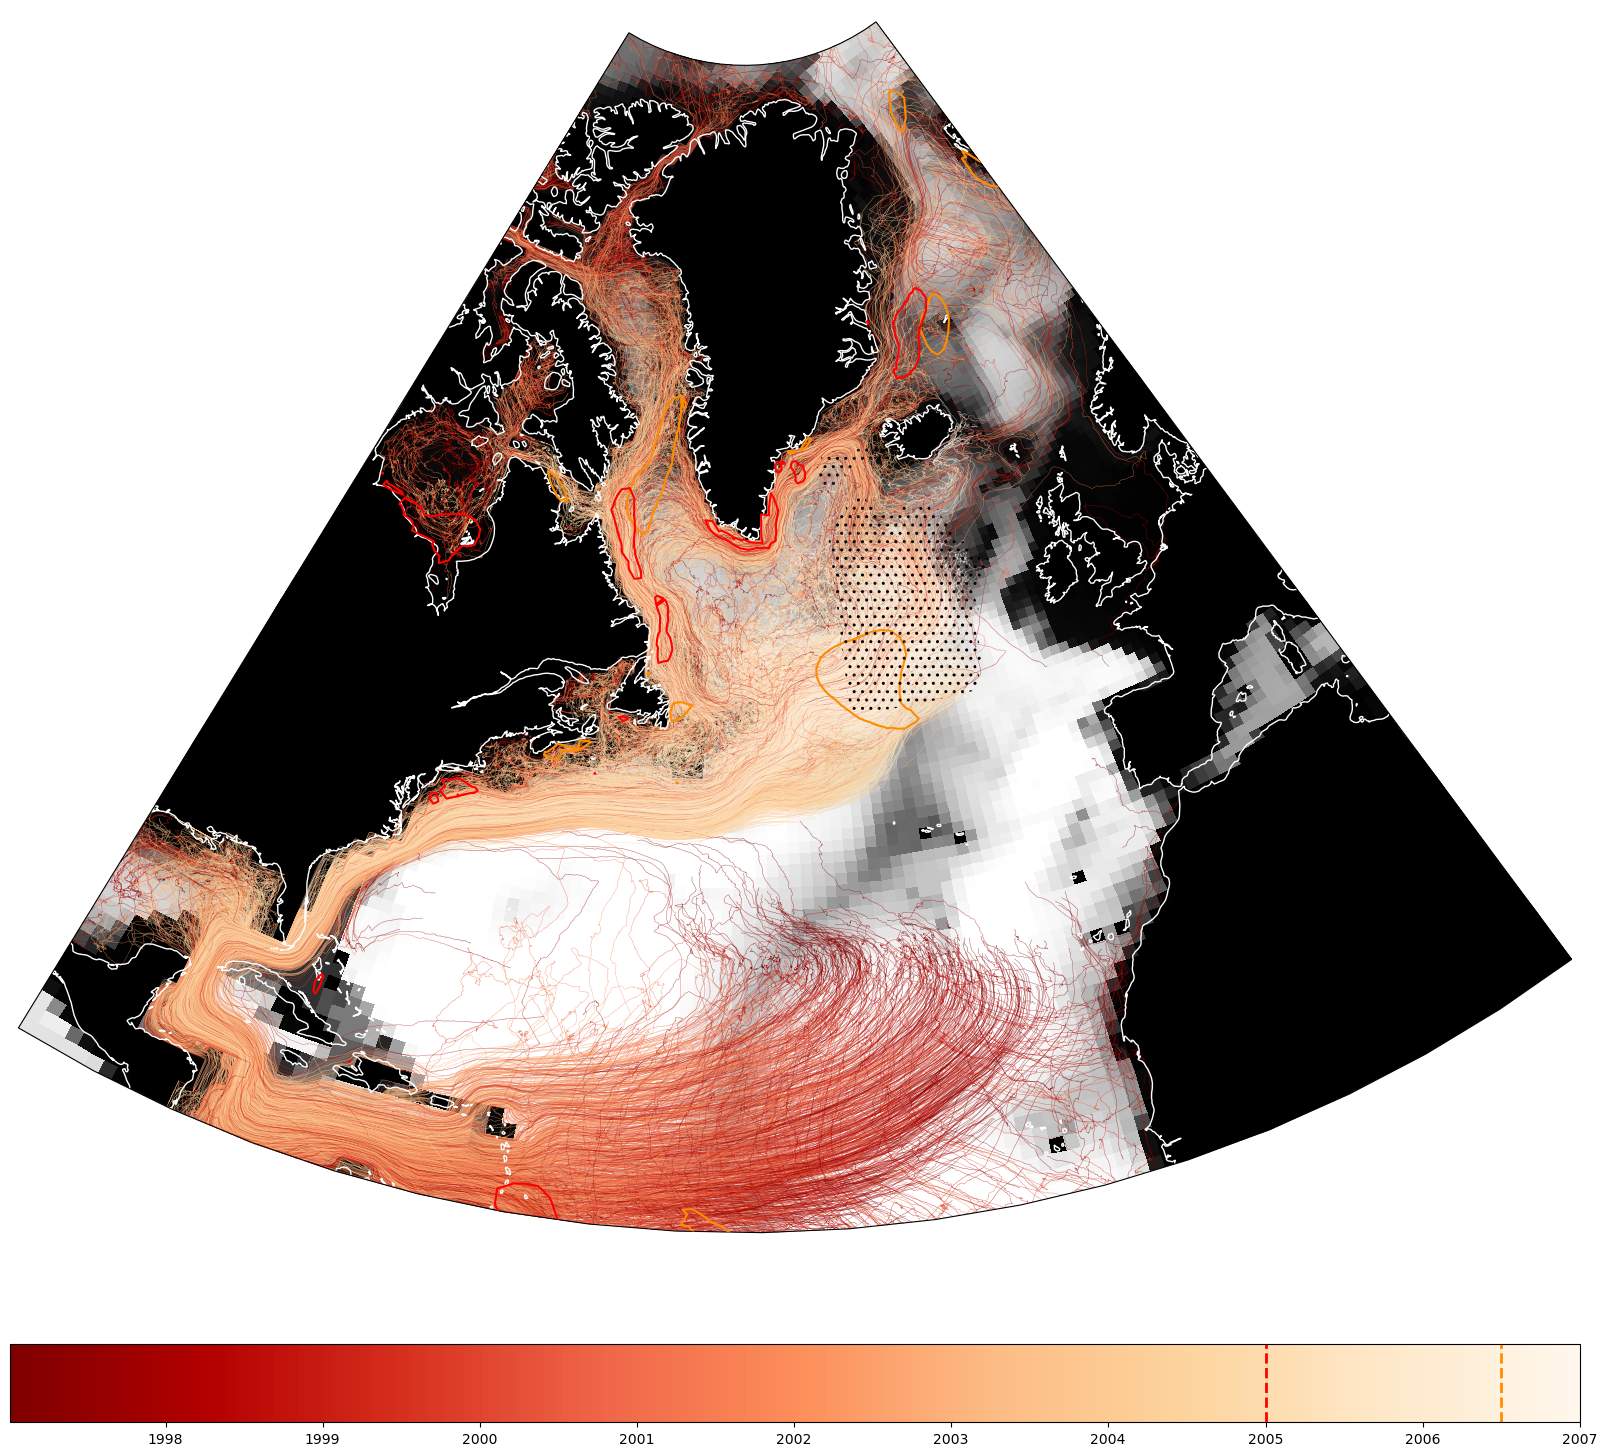

In [23]:
pretty_stream_plot(
    lats,
    lons,
    times,
    init_bool,
    projection,
    cmap = salty_time_cmap,
    extent = extent,
    darken = 0.75,
    alpha = 0.75,
    levels = [0.15],
    # particle_bins=1,
    # bins=5,
    # north=1000,
    # south=-1000,
    # plot_lines=True,
    save_as='figure4(a)',
)